In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.projections import PolarAxes
import mpl_toolkits.axisartist.grid_finder as grid_finder
import mpl_toolkits.axisartist.floating_axes as floating_axes

%matplotlib inline

In [33]:
def Taylor_diag(series, names):
    """
        Taylor Diagram : obs is reference data sample
        in a full diagram (0 --> npi)
        --------------------------------------------------------------------------
        Input: series     - dict with all time series (lists) to analyze  
               series[0]  - is the observation, the reference by default.
    """
    corr,std ={},{}
    for i in series.keys():
        corr[i] = np.ma.corrcoef(series[0],series[i])[1,0]
        std[i] = np.ma.std(series[i])/np.ma.std(series[0])
       
    reference_value = 1# ma.std(series[0])
    #print corr
    
    rlocs = np.concatenate((np.arange(0,-10,-0.25),[-0.95,-0.99],np.arange(0,10,0.25),[0.95,0.99]))
    str_rlocs = np.concatenate((np.arange(0,10,0.25),[0.95,0.99],np.arange(0,10,0.25),[0.95,0.99]))
    tlocs = np.arccos(rlocs)        # Conversion to polar angles
    grid_locator_1 = grid_finder.FixedLocator(tlocs)    # Positions
    tick_formatter_1 = grid_finder.DictFormatter(dict(zip(tlocs, map(str,rlocs))))

    str_locs2 = np.arange(-10,11,0.5)
    tlocs2 =  np.arange(-10,11,0.5)      
       
    grid_locator_2 = grid_finder.FixedLocator(tlocs2)  # ALEKS: THIS IS NOT USED ANYWHERE, CHECK
    tick_formatter_2 = grid_finder.DictFormatter(dict(zip(tlocs2, map(str,str_locs2))))
    
    base_transform = PolarAxes.PolarTransform()
    
    smin = 0
    smax = 2.5

    grid_helper = floating_axes.GridHelperCurveLinear(
        base_transform,
        extremes=(0,np.pi, # 1st quadrant
                  smin,smax),
        grid_locator1=grid_locator_1,
        #grid_locator2=grid_locator_2,
        tick_formatter1=tick_formatter_1,
        tick_formatter2=tick_formatter_2)
    
    fig = plt.figure(figsize=(10,5), dpi=100)
    ax = floating_axes.FloatingSubplot(fig, 111, grid_helper=grid_helper)

    fig.add_subplot(ax)
    ax.axis["top"].set_axis_direction("bottom") 
    ax.axis["top"].toggle(ticklabels=True, label=True)
    ax.axis["top"].major_ticklabels.set_axis_direction("top")
    ax.axis["top"].label.set_axis_direction("top")
    ax.axis["top"].label.set_text("Correlation Coefficient")

    ax.axis["left"].set_axis_direction("bottom") 
    ax.axis["left"].label.set_text("Standard Deviation")

    ax.axis["right"].set_axis_direction("top") 
    ax.axis["right"].toggle(ticklabels=True, label=True)
    ax.axis["right"].set_visible(True)
    ax.axis["right"].major_ticklabels.set_axis_direction("bottom")
    #ax.axis["right"].label.set_text("Standard Deviation")
    
    ax.axis["bottom"].set_visible(False) 
    ax.grid(True)
    ax = ax.get_aux_axes(base_transform)

    t = np.linspace(0, np.pi)
    r = np.zeros_like(t) + reference_value
    ax.plot(t,r, 'k--', label='_')

    rs,ts = np.meshgrid(np.linspace(smin,smax), np.linspace(0,np.pi))

    rms = np.sqrt(reference_value**2 + rs**2 - 2*reference_value*rs*np.cos(ts))
    CS =ax.contour(ts, rs,rms, cmap=plt.matplotlib.cm.bone)
    plt.clabel(CS, inline=1, fontsize=10)
    
    ax.plot(np.arccos(0.9999),reference_value,'k',marker='*',ls='', ms=10)
    aux = range(1,len(corr))
    #del aux[reference_value]

    colors = plt.matplotlib.cm.jet(np.linspace(0,1,len(corr)))
    
    for i in aux:
        ax.plot(np.arccos(corr[i]), std[i],c=colors[i],alpha =0.7,ms=15,marker='o',label=" %s" %names[i])
        ax.text(np.arccos(corr[i]), std[i],"%s"%i, fontsize=12)
    plt.legend(bbox_to_anchor=(1.5, 1),prop=dict(size='large'),loc='best')
    plt.savefig('example2.png', dpi=300)
    return


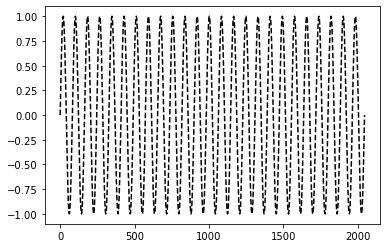

In [10]:
z = np.linspace(0,2048,2048)
x = np.sin(50*np.pi*z)
y = np.cos(50*np.pi*z)
x2 = 2*np.sin(50*np.pi*z)

plt.plot(x, 'k--')

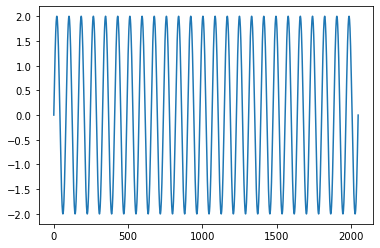

In [11]:
plt.plot(x2)

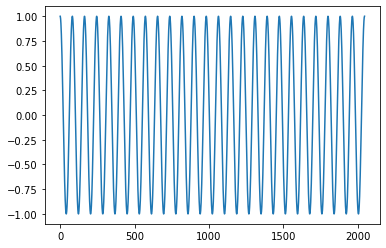

In [12]:
plt.plot(y)

In [13]:


series ={}
series[0] = x  # the first term will be always the reference_valueerence signal 
series[1]= x2
series[2]= y



/tmp/ipykernel_6877/4192084085.py:19: RuntimeWarning: invalid value encountered in arccos
  tlocs = np.arccos(rlocs)        # Conversion to polar angles


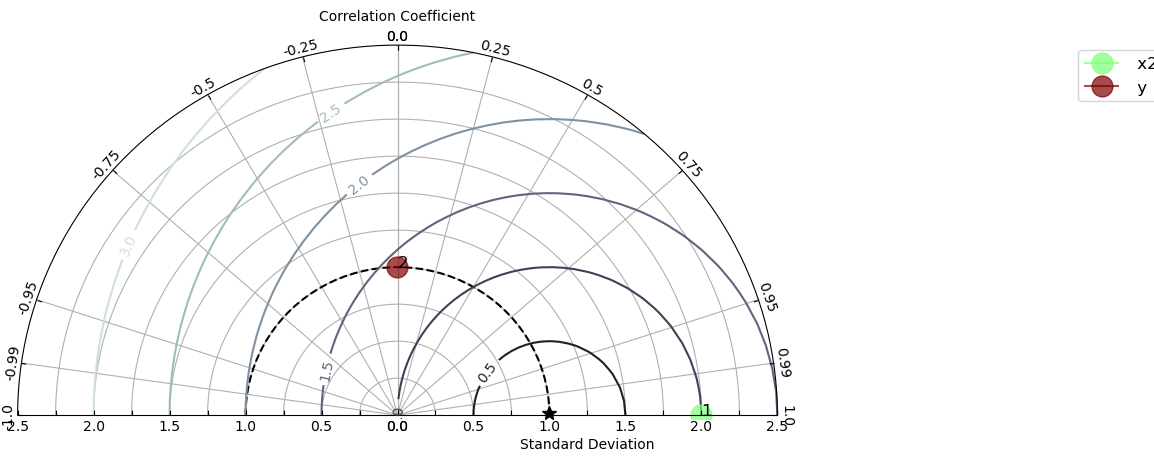

In [34]:
Taylor_diag(series,['x','x2','y'])